In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
from matplotlib.animation import FuncAnimation
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as stats


In [3]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    minute_of_day = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
        minute_of_day.append(60*time.hour+time.minute)
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    df['Minute of Day'] = np.array(minute_of_day)
    return df

def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]

In [4]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [5]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}

In [6]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
RT.head()

,Interval,GMT Interval,Settlement Location Name,PNODE Name,LMP,MLC,MCC,MEC
0,01/01/2018 00:05:00,01/01/2018 06:05:00,AEC,SOUC,255.8769,5.4654,0.0000,250.4115
1,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_CSWS,CSWS_AECC_LA,262.5802,5.0312,7.1375,250.4115
2,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_ELKINS,CSWSELKINSUNELKINS_RA,270.2234,3.0020,16.8099,250.4115
3,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_FITZHUGH,CSWSFITZHUGHPLT1,257.2724,6.8609,0.0000,250.4115
4,01/01/2018 00:05:00,01/01/2018 06:05:00,AECC_FLTCREEK,CSWSFLINTCRKUN1_JOU_AECC_RA,266.5657,-3.0577,19.2119,250.4115


In [7]:
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.head()

,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 00:05:00,01/01/2018 00:05:00,246.567610,2018-01-01,00:05:00,00:00:00,True,1,1,5
01/01/2018 00:10:00,01/01/2018 00:10:00,64.864068,2018-01-01,00:10:00,00:00:00,True,1,1,10
01/01/2018 00:15:00,01/01/2018 00:15:00,164.686048,2018-01-01,00:15:00,00:00:00,True,1,1,15
01/01/2018 00:20:00,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20
01/01/2018 00:25:00,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25


In [8]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)
DA2018.head()

,Interval,GMTIntervalEnd,Settlement Location,Pnode,LMP,MLC,MCC,MEC
0,01/01/2018 01:00:00,01/01/2018 07:00:00,AEC,SOUC,39.6809,0.8665,0.5970,38.2174
1,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_CSWS,CSWS_AECC_LA,38.3723,0.7331,-0.5781,38.2173
2,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_ELKINS,CSWSELKINSUNELKINS_RA,38.4189,0.4093,-0.2077,38.2173
3,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FITZHUGH,CSWSFITZHUGHPLT1,38.5076,1.0540,-0.7637,38.2173
4,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FLTCREEK,CSWSFLINTCRKUN1_JOU_AECC_RA,37.8395,-0.4387,0.0609,38.2173


In [9]:
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018.head()

,Interval,GMTIntervalEnd,Settlement Location,Pnode,LMP,MLC,MCC,MEC
0,01/01/2018 01:00:00,01/01/2018 07:00:00,AEC,SOUC,39.6809,0.8665,0.5970,38.2174
1,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_CSWS,CSWS_AECC_LA,38.3723,0.7331,-0.5781,38.2173
2,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_ELKINS,CSWSELKINSUNELKINS_RA,38.4189,0.4093,-0.2077,38.2173
3,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FITZHUGH,CSWSFITZHUGHPLT1,38.5076,1.0540,-0.7637,38.2173
4,01/01/2018 01:00:00,01/01/2018 07:00:00,AECC_FLTCREEK,CSWSFLINTCRKUN1_JOU_AECC_RA,37.8395,-0.4387,0.0609,38.2173


In [10]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()
def pe(prediction, test):
    return (abs((prediction - test)/test))*100
def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df

In [11]:
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018_5min = filler(comparison, 'LMP_DA')
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self',
                                             'Local Time_price':'Local Time'})

In [12]:
def ssr_split4(df, s):
    if df.shape[0]>(288/4):
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        concat = [smallest] + [ssr_split4(largest, s)]
        return concat
    else:
        return df

def unnest(l, empty_l):
    for i in l:
        if type(i) == list:
            unnest(i, empty_l)
        else:
            empty_l.append(i)
            
def unnested_df(l):
    for df in l:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means
    unnested = pd.concat(l)
    unnested['Time'] = unnested.index
    unnested = unnested.sort_values('Time')
    return unnested

def sklearn_clusters(train_df, test_df):
    # converting datetime to float
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    minutes = []
    for time in test_df.index:
        minutes.append(time.hour * 60 + time.minute)
    test_df['minutes'] = np.array(minutes)
    # testing existing module
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=3)
    regr_1.fit(X, y)
    # Predict
    X_test = test_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    test_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(test_df[test_df['sklearn cluster']==price])
    return branch_dfs

In [18]:
# system-wide, 5 predictors
# multi or single clustered -- comparings R^2

np.seterr(divide='print')
def err_handler(type, flag):
    print("Floating point error (%s) with flag %s" % (type, flag))
saved_handler = np.seterrcall(err_handler)
save_err = np.seterr(all='call')

n = 10
custom_PE_array = np.empty(n)
custom_R2_array = np.empty(n)
sklearn_PE_array = np.empty(n)
sklearn_R2_array = np.empty(n)

check = 0
R2 = []

for i in range(n):
    custom_PE_list = []
    custom_R2_list = []
    sklearn_PE_list = []
    sklearn_R2_list = []

    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        test_data_copy = test_data.copy()
        
        size = test_data_copy.index.shape[0]
        test_data_copy['fitted RT (custom)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            custom_R2_list.append(result.rsquared)
            for hour in cluster.index:
                try:
                    test_data_copy['fitted RT (custom)'].loc[hour] = ( 
                                                test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result.params[4] + 
                                                test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                except:
                    continue
        custom_PE_list.append(pe(test_data_copy['fitted RT (custom)'], test_data_copy['LMP_RT']).mean())
        
                
        branch_dfs = sklearn_clusters(train_data, test_data)
        size = test_data_copy.index.shape[0]
        test_data_copy['fitted RT (sklearn)'] = np.zeros(size) 
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            sklearn_R2_list.append(result.rsquared)
            R2.append(result.rsquared)
            for hour in cluster.index:
                test_data_copy['fitted RT (sklearn)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
        sklearn_PE_list.append(pe(test_data_copy['fitted RT (sklearn)'], test_data_copy['LMP_RT']).mean())
            
            
        check += np.where(test_data_copy['fitted RT (custom)']==0.0,1,0).sum()
        check += np.where(test_data_copy['fitted RT (sklearn)']==0.0,1,0).sum()
        if check > 0:
            print(check)
            break
                
    print('{}%'.format(10*i))

    custom_PE_array[i] = np.array(custom_PE_list).mean()
    custom_R2_array[i] = np.array(custom_R2_list).mean()
    sklearn_PE_array[i] = np.array(sklearn_PE_list).mean()
    sklearn_R2_array[i] = np.array(sklearn_R2_list).mean()


print('custom cluster:\n\tMAPE: {};\n\tMean R^2: {};'.format(custom_PE_array.mean(),custom_R2_array.mean()))
print('sklearn clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(sklearn_PE_array.mean(),sklearn_R2_array.mean()))
print('errors filling predictions: {}'.format(check))
len1 = len(R2)
for value in R2:
    if (value == np.inf) or (value == -np.inf):
        R2.remove(value)
len2 = len(R2)
print('mean of all valid R^2: {}'.format(np.nanmean(R2)))
print('{}% of R^2 were invalid (nan or inf)'.format(100*(1 - len2/len1)))

Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
0%
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
10%
Floating point error (invalid value) with flag 8
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
20%
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
30%
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) 

In [13]:
# raising so many warnings, but was not able to track them down

In [13]:
def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    return means_d

In [15]:
np.seterr(divide='print')
def err_handler(type, flag):
    print("Floating point error (%s) with flag %s" % (type, flag))
saved_handler = np.seterrcall(err_handler)
save_err = np.seterr(all='call')
n = 10
sklearn_PE_array = np.empty(n)
pvalues = {'Intercept':[],
          'LMP_DA':[],
          'RT_sem':[],
          'DA_sem':[],
          'Load':[],
          'Wind':[]}
for i in range(n):
    sklearn_PE_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (sklearn)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            for hour in cluster.index:
                test_data_copy['fitted RT (sklearn)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            for predictor in result.pvalues.index:
                pvalues[predictor].append(result.pvalues.loc[predictor])
        sklearn_PE_list.append(pe(test_data_copy['fitted RT (sklearn)'], test_data_copy['LMP_RT']).mean())
    sklearn_PE_array[i] = np.array(sklearn_PE_list).mean()
    print('{}%'.format(10*i))
print('MAPE: {}'.format(sklearn_PE_array.mean()))
means_dict(pvalues)

Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating point error (invalid value) with flag 8
Floating

Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
70%
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with flag 1
Floating point error (divide by zero) with fla

{'Intercept': 0.387312283077633,
 'LMP_DA': 0.36846743596895326,
 'RT_sem': 0.08842869552425589,
 'DA_sem': 0.37199701886546843,
 'Load': 0.2655923758124944,
 'Wind': 0.1961371615471715}

Questions
- Why does the warning come up when result is accessed?
- Why are p-values so high? -> evaluate each regression separately

In [16]:
# calculate p-values for each predictor - forward selection

np.seterr(divide='ignore',invalid='ignore') # ignore errors for n=100
n = 10
RTsem_model = []
DA_model = []
load_model = []
DAsem_model = []
wind_model = []
for i in range(n):
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (sklearn)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ RT_sem", data=cluster).fit()
            RTsem_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ LMP_DA", data=cluster).fit()
            DA_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ Load", data=cluster).fit()
            load_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ DA_sem", data=cluster).fit()
            DAsem_model.append(result.pvalues[1])
            result = smf.ols(formula="LMP_RT ~ Wind", data=cluster).fit()
            wind_model.append(result.pvalues[1])

    if i%(10)==0:
        print('{}%'.format(i))
            
print('p-values:')
print('\tRT_sem: {}'.format(np.nanmean(RTsem_model).mean()))
print('\tDA_sem: {}'.format(np.nanmean(DAsem_model).mean()))
print('\tLMP_DA: {}'.format(np.nanmean(DA_model).mean()))
print('\tLoad: {}'.format(np.nanmean(load_model).mean()))
print('\tWind: {}'.format(np.nanmean(wind_model).mean()))


0%
p-values:
	RT_sem: 0.09732926428751672
	DA_sem: 0.41141995689942934
	LMP_DA: 0.22645149554351612
	Load: 0.26766184828738016
	Wind: 0.2436339970489644


In [18]:
result.pvalues

Intercept    0.000009
Wind         0.006250
dtype: float64

#### p-values test
still many warnings, but results were (for n = 100 * 12):

|factors|    factor p   | intercept p +- sem  |
|-------|---------------|---------------------|
|RT_sem |     0.094     |     0.011 +- 0.001  |
|DA_sem |     0.407     |     0.061 +- 0.002  |
|LMP_DA |     0.230     |     0.368 +- 0.003  |
|Load   |     0.265     |     0.356 +- 0.003  |
|Wind   |     0.244     |     0.073 +- 0.002  |

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
MAPE: 7.488507790236099
MAPE for Adjusted R^2 > 0.8: 6.746837455841167
46.666666666666664% of months had Adjusted R^2 > 0.8


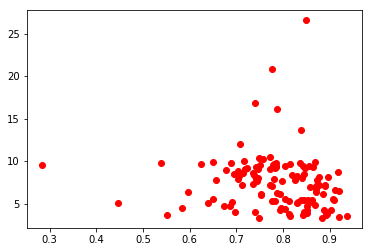

In [19]:
# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
sklearn_PE_array = np.zeros(n)
best_PE_array = np.zeros(n)
all_R2adj = []
all_PE = []
k = 0
r = 0.8
for i in range(n):
    sklearn_PE_list = []
    best_PE_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (sklearn)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        month_R2adj = []
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            month_R2adj.append(result.rsquared_adj)
            for hour in cluster.index:
                test_data_copy['fitted RT (sklearn)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
        
        PE = pe(test_data_copy['fitted RT (sklearn)'], test_data_copy['LMP_RT']).mean()
        
        if np.nanmean(np.array(month_R2adj)) > r:
            best_PE_list.append(PE)
            k += 1
        sklearn_PE_list.append(PE)
        
        all_R2adj.append(np.nanmean(np.array(month_R2adj)))
        all_PE.append(PE)
        
    sklearn_PE_array[i] = np.array(sklearn_PE_list).mean()
    best_PE_array[i] = np.array(best_PE_list).mean()

    print('{}%'.format(10*i))
print('MAPE: {}'.format(sklearn_PE_array.mean()))
print('MAPE for Adjusted R^2 > {}: {}'.format(r, best_PE_array.mean()))
print('{}% of months had Adjusted R^2 > {}'.format(100*k/(12*n), r))
plt.plot(np.array(all_R2adj), np.array(all_PE), 'ro')

In [20]:
# compare MAPE between predictions with 3 vs 5 variables

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
PE_5_array = np.zeros(n)
PE_3_array = np.zeros(n)
PE_0_array = np.zeros(n)

for i in range(n):
    five_list = []
    three_list = []
    no_errors_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (all 5)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (3)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (no errors)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result5 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            result3 = smf.ols(formula="LMP_RT ~ RT_sem + DA_sem + Wind", data=cluster).fit()
            result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + Wind", data=cluster).fit()            
            for hour in cluster.index:
                test_data_copy['fitted RT (all 5)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result5.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result5.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result5.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result5.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result5.params[1] + 
                                            result5.params[0])
                test_data_copy['fitted RT (3)'].loc[hour] = (  
                                            test_data_copy['Wind'].loc[hour]*result3.params[3] + 
                                            test_data_copy['DA_sem'].loc[hour]*result3.params[2] + 
                                            test_data_copy['RT_sem'].loc[hour]*result3.params[1] + 
                                            result3.params[0])
                test_data_copy['fitted RT (no errors)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result.params[3] + 
                                            test_data_copy['Load'].loc[hour]*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                
        five_list.append(pe(test_data_copy['fitted RT (all 5)'], test_data_copy['LMP_RT']).mean())
        three_list.append(pe(test_data_copy['fitted RT (3)'], test_data_copy['LMP_RT']).mean())
        no_errors_list.append(pe(test_data_copy['fitted RT (no errors)'], test_data_copy['LMP_RT']).mean())

        
    PE_5_array[i] = np.array(five_list).mean()
    PE_3_array[i] = np.array(three_list).mean()
    PE_0_array[i] = np.array(no_errors_list).mean()
    print('{}%'.format(10*i))
    
print('RT_sem + DA_sem + Wind\'s MAPE: {}'.format(PE_3_array.mean()))
print('all 5 predictors\' MAPE: {}'.format(PE_5_array.mean()))
print('LMP_DA + Load + Wind\'s MAPE: {}'.format(PE_0_array.mean()))


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
RT_sem + DA_sem + Wind's MAPE: 11.882728032448242
all 5 predictors' MAPE: 9.304217949386437
LMP_DA + Load + Wind's MAPE: 22.187864946130887


Although RT_sem, DA_sem and Wind have significantly lower p-values, adding Load and LMP_DA to the model reduces MAPE.
Simply using the most intuitive LMP_DA, Wind and Load yields poor predictions.

In [21]:
# let's add weekend/weekday feature to model 
# -- because of current structure, model will take mean of weekdays (1) and weekends (0)

# compare MAPE between predictions with 6 vs 5 variables

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
PE_5_array = np.zeros(n)
PE_6_array = np.zeros(n)
weekday_p = []
for i in range(n):
    five_list = []
    six_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (5)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (6)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result5 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
            weekday_p.append(result6.pvalues[-1])
            for hour in cluster.index:
                test_data_copy['fitted RT (5)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour]*result5.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result5.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result5.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result5.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result5.params[1] + 
                                            result5.params[0])
                test_data_copy['fitted RT (6)'].loc[hour] = (  
                                            test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                            test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                            result6.params[0])
                
        five_list.append(pe(test_data_copy['fitted RT (5)'], test_data_copy['LMP_RT']).mean())
        six_list.append(pe(test_data_copy['fitted RT (6)'], test_data_copy['LMP_RT']).mean())

        
    PE_5_array[i] = np.array(five_list).mean()
    PE_6_array[i] = np.array(six_list).mean()
    print('{}%'.format(10*i))
    
print('6 predictors\' MAPE: {}'.format(PE_6_array.mean()))
print('5 predictors\' MAPE: {}'.format(PE_5_array.mean()))


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
6 predictors' MAPE: 7.008425410708936
5 predictors' MAPE: 7.154042283702587


In [22]:
# adding day of the week feature slightly improved model

In [23]:
# let's compare single-cluster vs multi-cluster

# let's add weekend/weekday feature to model 
# -- because of current structure, model will take mean of weekdays (1) and weekends (0)

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
single_array = np.zeros(n)
PE_6_array = np.zeros(n)
weekday_p = []
for i in range(n):
    single_list = []
    six_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        
        test_data_copy = test_data.copy()
        test_data_copy['fitted RT (multi)'] = np.zeros(test_data_copy.index.shape[0])
        result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=train_data).fit()
        test_data_copy['fitted RT (single)'] = (  
                                            test_data_copy['Weekday']*result.params[6] + 
                                            test_data_copy['Wind']*result.params[5] + 
                                            test_data_copy['Load']*result.params[4] + 
                                            test_data_copy['DA_sem']*result.params[3] + 
                                            test_data_copy['RT_sem']*result.params[2] + 
                                            test_data_copy['LMP_DA']*result.params[1] + 
                                            result.params[0])


        branch_dfs = sklearn_clusters(train_data, test_data)
        for cluster in branch_dfs:
            result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
            weekday_p.append(result6.pvalues[-1])
            for hour in cluster.index:
                test_data_copy['fitted RT (multi)'].loc[hour] = (  
                                            test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                            test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                            test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                            result6.params[0])
                
        single_list.append(pe(test_data_copy['fitted RT (single)'], test_data_copy['LMP_RT']).mean())
        six_list.append(pe(test_data_copy['fitted RT (multi)'], test_data_copy['LMP_RT']).mean())

        
    single_array[i] = np.array(single_list).mean()
    PE_6_array[i] = np.array(six_list).mean()
    print('{}%'.format(10*i))
    
print('multi-cluster MAPE: {}'.format(PE_6_array.mean()))
print('single-cluster MAPE: {}'.format(single_array.mean()))


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multi-cluster MAPE: 6.956883052852858
single-cluster MAPE: 13.093552370876854


In [24]:
# multi-clustering performs quite better than single-clustering in terms of MAPE (7.0% vs 13.6%)

In [13]:
def sklearn_clusters_d(train_df, test_df, depth):
    # converting datetime to float
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    minutes = []
    for time in test_df.index:
        minutes.append(time.hour * 60 + time.minute)
    test_df['minutes'] = np.array(minutes)
    # testing existing module
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = test_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    test_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(test_df[test_df['sklearn cluster']==price])
    return branch_dfs

In [26]:
# comparing depths

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
d2_array = np.zeros(n)
d3_array = np.zeros(n)
d4_array = np.zeros(n)
d5_array = np.zeros(n)
for i in range(n):
    d2_list = []
    d3_list = []
    d4_list = []
    d5_list = []
    ds = [d2_list, d3_list, d4_list, d5_list]
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        
        for d in range(2,6):
            test_data_copy['pred RT '+str(d)] = np.zeros(test_data_copy.index.shape[0])
            branch_dfs = sklearn_clusters_d(train_data, test_data, d)
            for cluster in branch_dfs:
                result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
                for hour in cluster.index:
                    test_data_copy['pred RT '+str(d)].loc[hour] = (  
                                                test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                                test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                                test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                                result6.params[0])
            ds[d-2].append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
        
    d2_array[i] = np.array(d2_list).mean()
    d3_array[i] = np.array(d3_list).mean()
    d4_array[i] = np.array(d4_list).mean()
    d5_array[i] = np.array(d5_list).mean()
    print('{}%'.format(10*i))

print('comparing MAPE of different depths for regression trees')
print('d = 2: {}'.format(d2_array.mean()))
print('d = 3: {}'.format(d3_array.mean()))
print('d = 4: {}'.format(d4_array.mean()))
print('d = 5: {}'.format(d5_array.mean()))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
comparing MAPE of different depths for regression trees
d = 2: 8.089473079055916
d = 3: 6.943014604001047
d = 4: 5.799335666763648
d = 5: 4.6928111142242175


In [21]:
def sklearn_clusters_plot(train_df, test_df, depth):
    # converting datetime to float
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    minutes = []
    for time in test_df.index:
        minutes.append(time.hour * 60 + time.minute)
    test_df['minutes'] = np.array(minutes)
    # testing existing module
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = test_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    test_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(test_df[test_df['sklearn cluster']==price])
    plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth="+str(depth), linewidth=2)
    plt.legend()
    return branch_dfs

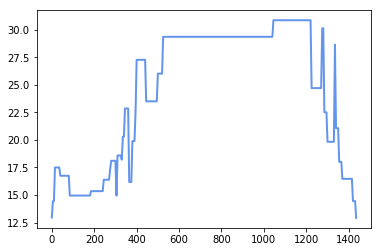

In [78]:
branch_dfs = sklearn_clusters_plot(train_data, test_data, 5)

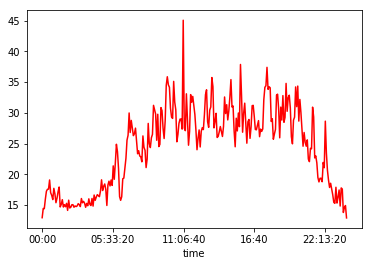

In [79]:
plt.plot(train_data.index, train_data['LMP_RT'],'red')

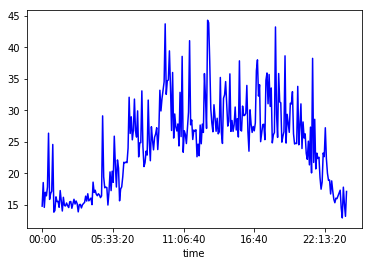

In [80]:
plt.plot(train_data.index, test_data['LMP_RT'],'blue')

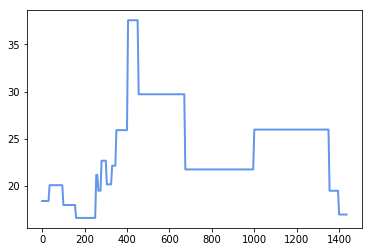

In [30]:
branch_dfs = sklearn_clusters_plot(train_data, test_data, 4)


In [31]:
# comparison of depths (2, 3, 4 and 5) showed that the larger d is, the smaller MAPE is
# but at some point it should not be beneficial to increase depth bc of overfit

In [32]:
# comparing depths

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
# we'll compare depths from an initial d = d_init to a final d = d_final with increments of 1
d_initial = 2
d_final = 10
MAPE_arrays = []
for i in range(d_initial, d_final+1):
    MAPE_arrays.append(np.zeros(n))

errors = 0
for i in range(n):
    ds = []
    for p in range(d_initial, d_final+1):
        ds.append(list())
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        
        for d in range(d_initial, d_final+1):
            test_data_copy['pred RT '+str(d)] = np.zeros(test_data_copy.index.shape[0])
            branch_dfs = sklearn_clusters_d(train_data, test_data, d)
            for cluster in branch_dfs:
                try:
                    result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
                    for hour in cluster.index:
                        test_data_copy['pred RT '+str(d)].loc[hour] = (  
                                                    test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                                    test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                                    test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                                    test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                                    test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                                    test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                                    result6.params[0])
                except:
                    errors += 1
                    print('error occured with d = {}'.format(d))
                    continue
            ds[d-d_initial].append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
    
    index = d_initial
    for array in MAPE_arrays:
        array[i] = np.array(ds[index-d_initial]).mean()
        index += 1
    print('{}%'.format(10*i))

print('comparing MAPE of regression trees with different depths')
print('\tMAPE \u00B1 std')
for i in range(d_initial,d_final+1):
    print('\td = {}: {} \u00B1 {}'.format(i, MAPE_arrays[i-d_initial].mean(), MAPE_arrays[i-d_initial].std()))
print('# of errors: {}'.format(errors))

0%
10%
20%
error occured with d = 10
30%
40%
50%
60%
70%
80%
90%
comparing MAPE of regression trees with different depths
	MAPE ± std
	d = 2: 8.407681324050861 ± 0.7440273310771178
	d = 3: 7.170462368908829 ± 0.4021092998113064
	d = 4: 5.926922834555912 ± 0.24516729193430942
	d = 5: 4.745005382542542 ± 0.19107484059031934
	d = 6: 3.6168534546514537 ± 0.1460103953647496
	d = 7: 2.5905310494423994 ± 0.15616322803322233
	d = 8: 1.7452835706333722 ± 0.12824069358342013
	d = 9: 1.1115065128301422 ± 0.14091356116596163
	d = 10: 0.6519155932474302 ± 0.12522377004976426
# of errors: 56


In [35]:
print('comparing MAPE of regression trees with different depths')
print('\t\tMAPE \u00B1 std')
for i in range(d_initial,d_final+1):
    print('\td = {}: {} \u00B1 {}'.format(i, round(MAPE_arrays[i-d_initial].mean(),2), round(MAPE_arrays[i-d_initial].std(),2)))

comparing MAPE of regression trees with different depths
		MAPE ± std
	d = 2: 8.41 ± 0.74
	d = 3: 7.17 ± 0.4
	d = 4: 5.93 ± 0.25
	d = 5: 4.75 ± 0.19
	d = 6: 3.62 ± 0.15
	d = 7: 2.59 ± 0.16
	d = 8: 1.75 ± 0.13
	d = 9: 1.11 ± 0.14
	d = 10: 0.65 ± 0.13


In [ ]:
# incredibly good results for depths as high as d = 10 (MAPE = 0.56%)

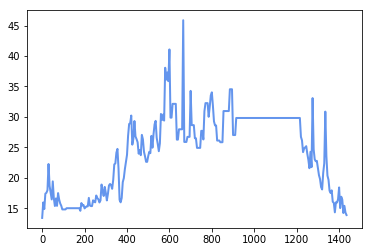

In [62]:
branch_dfs = sklearn_clusters_plot(train_data, test_data, 10)

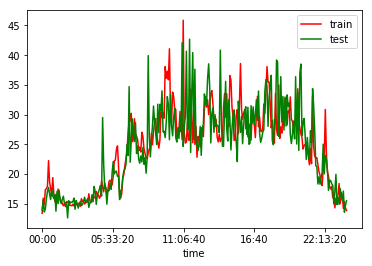

In [61]:
plt.plot(train_data.index, train_data['LMP_RT'],'red',label='train')
plt.plot(test_data.index, test_data['LMP_RT'],'green',label='test')
plt.legend()

#### Fixed training-testing method

In [24]:
def sklearn_clusters_2(train_df, depth, plot):
    # converting datetime to int
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = train_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    train_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(train_df[train_df['sklearn cluster']==price])
    if plot == True:
        plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth="+str(depth), linewidth=2)
        plt.legend()
    return branch_dfs

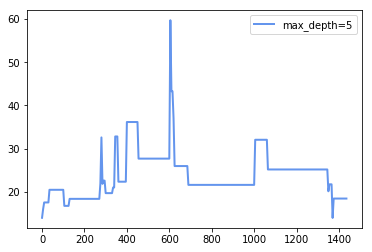

In [24]:
branch_dfs = sklearn_clusters_2(train_data, 5, True)

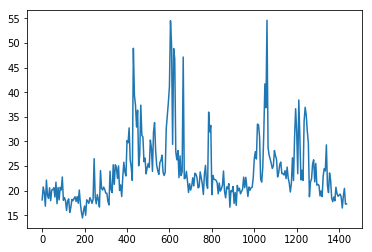

In [108]:
plt.plot(train_data['minutes'], train_data['LMP_RT'])

In [25]:
# comparing depths

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
# we'll compare depths from an initial d = d_init to a final d = d_final with increments of 1
d_initial = 2
d_final = 5
MAPE_arrays = []
for i in range(d_initial, d_final+1):
    MAPE_arrays.append(np.zeros(n))

errors = 0
for i in range(n):
    ds = []
    for p in range(d_initial, d_final+1):
        ds.append(list())
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        
        for d in range(d_initial, d_final+1):
            test_data_copy['pred RT '+str(d)] = np.zeros(test_data_copy.index.shape[0])
            branch_dfs = sklearn_clusters_2(train_data, d, False)
            for cluster in branch_dfs:
                try:
                    result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
                    for hour in cluster.index:
                        test_data_copy['pred RT '+str(d)].loc[hour] = (  
                                                    test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                                    test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                                    test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                                    test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                                    test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                                    test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                                    result6.params[0])
                except:
                    errors += 1
                    print('error occured with d = {}'.format(d))
                    continue
            ds[d-d_initial].append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
    
    index = d_initial
    for array in MAPE_arrays:
        array[i] = np.array(ds[index-d_initial]).mean()
        index += 1
    print('{}%'.format(10*i))

print('comparing MAPE of regression trees with different depths')
print('\tMAPE \u00B1 std')
for i in range(d_initial,d_final+1):
    print('\td = {}: {} \u00B1 {}'.format(i, MAPE_arrays[i-d_initial].mean(), MAPE_arrays[i-d_initial].std()))
print('# of errors: {}'.format(errors))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
comparing MAPE of regression trees with different depths
	MAPE ± std
	d = 2: 12.40468274878884 ± 0.42724541947414807
	d = 3: 14.40857031790246 ± 1.1380524206655804
	d = 4: 19.35310335372742 ± 2.9658900462060314
	d = 5: 23.49983705299136 ± 4.44640172840603
# of errors: 0


In [15]:
# comparing depths and single cluster

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 10
# we'll compare depths from an initial d = d_init to a final d = d_final with increments of 1
d_initial = 1
d_final = 3
MAPE_arrays = []
for i in range(d_initial, d_final+1):
    MAPE_arrays.append(np.zeros(n))
single_array = np.zeros(n)
errors = 0
for i in range(n):
    ds = []
    single_list = []
    for p in range(d_initial, d_final+1):
        ds.append(list())
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        
        result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=train_data).fit()
        test_data_copy['pred RT (single)'] = (  
                                            test_data_copy['Weekday']*result6.params[6] + 
                                            test_data_copy['Wind']*result6.params[5] + 
                                            test_data_copy['Load']*result6.params[4] + 
                                            test_data_copy['DA_sem']*result6.params[3] + 
                                            test_data_copy['RT_sem']*result6.params[2] + 
                                            test_data_copy['LMP_DA']*result6.params[1] + 
                                            result6.params[0])
        single_list.append(pe(test_data_copy['pred RT (single)'],test_data_copy['LMP_RT']).mean())
        for d in range(d_initial, d_final+1):
            test_data_copy['pred RT '+str(d)] = np.zeros(test_data_copy.index.shape[0])
            branch_dfs = sklearn_clusters_2(train_data, d, False)
            for cluster in branch_dfs:
                try:
                    result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
                    for hour in cluster.index:
                        test_data_copy['pred RT '+str(d)].loc[hour] = (  
                                                    test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                                    test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                                    test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                                    test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                                    test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                                    test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                                    result6.params[0])
                except:
                    errors += 1
                    print('error occured with d = {}'.format(d))
                    continue
            ds[d-d_initial].append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
    
    index = d_initial
    for array in MAPE_arrays:
        array[i] = np.array(ds[index-d_initial]).mean()
        index += 1
    single_array[i] = np.array(single_list).mean()
    print('{}%'.format(10*i))

print('comparing MAPE of regression trees with different depths')
print('\tMAPE \u00B1 std')
for i in range(d_initial,d_final+1):
    print('\td = {}: {} \u00B1 {}'.format(i, MAPE_arrays[i-d_initial].mean(), MAPE_arrays[i-d_initial].std()))
print('\tsingle cluster: {} \u00B1 {}'.format(single_array.mean(), single_array.std()))
print('# of errors: {}'.format(errors))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
comparing MAPE of regression trees with different depths
	MAPE ± std
	d = 1: 12.624579513690126 ± 0.7064342521911523
	d = 2: 12.338035562426168 ± 0.5175246071324827
	d = 3: 14.761481702123945 ± 1.1718308293795756
	single cluster: 13.737925318951582 ± 0.8427346110672778
# of errors: 0


In [16]:
# d = 2, but filtering R^2

# I'll ignore warnings for the following test

np.seterr(divide='ignore',invalid='ignore')
n = 20
# we'll compare depths from an initial d = d_init to a final d = d_final with increments of 1
d_initial = 2
d_final = 2
MAPE_arrays = []
for i in range(d_initial, d_final+1):
    MAPE_arrays.append(np.zeros(n))
errors = 0
r = 0.85
k = 0
filtered_array = np.zeros(n)
for i in range(n):
    ds = []
    filtered_list = []
    for p in range(d_initial, d_final+1):
        ds.append(list())
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 
        test_data_copy = test_data.copy()
        
        for d in range(d_initial, d_final+1):
            test_data_copy['pred RT '+str(d)] = np.zeros(test_data_copy.index.shape[0])
            month_r2 = []
            branch_dfs = sklearn_clusters_2(train_data, d, False)
            for cluster in branch_dfs:
                try:
                    result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday", data=cluster).fit()
                    month_r2.append(result6.rsquared)
                    for hour in cluster.index:
                        test_data_copy['pred RT '+str(d)].loc[hour] = (  
                                                    test_data_copy['Weekday'].loc[hour]*result6.params[6] + 
                                                    test_data_copy['Wind'].loc[hour]*result6.params[5] + 
                                                    test_data_copy['Load'].loc[hour]*result6.params[4] + 
                                                    test_data_copy['DA_sem'].loc[hour]*result6.params[3] + 
                                                    test_data_copy['RT_sem'].loc[hour]*result6.params[2] + 
                                                    test_data_copy['LMP_DA'].loc[hour]*result6.params[1] + 
                                                    result6.params[0])
                except:
                    errors += 1
                    print('error occured with d = {}'.format(d))
                    continue
            ds[d-d_initial].append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
            if np.nanmean(np.array(month_r2)) > r:
                filtered_list.append(pe(test_data_copy['pred RT '+str(d)], test_data_copy['LMP_RT']).mean())
                k += 1
                
    index = d_initial
    for array in MAPE_arrays:
        array[i] = np.array(ds[index-d_initial]).mean()
        index += 1
    filtered_array[i] = np.array(filtered_list).mean()
    print('{}%'.format(5*i))

print('comparing MAPE of regression trees with different depths')
print('\tMAPE \u00B1 std')
for i in range(d_initial,d_final+1):
    print('\td = {}: {} \u00B1 {}'.format(i, MAPE_arrays[i-d_initial].mean(), MAPE_arrays[i-d_initial].std()))
print('filtered: {} \u00B1 {}'.format(filtered_array.mean(), filtered_array.std()))
print('{}% of months passed the filter'.format(100*k/(n*12)))
print('# of errors: {}'.format(errors))

0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
error occured with d = 2
65%
70%
75%
80%
85%
90%
95%
comparing MAPE of regression trees with different depths
	MAPE ± std
	d = 2: 12.816840758597028 ± 2.59869897326829
filtered: 10.43221111322608 ± 0.9611031173351265
45.833333333333336% of months passed the filter
# of errors: 1


In [17]:
filtered_array

array([ 9.33355489, 10.23037368, 11.55223479,  9.23323587, 11.10792279,
       11.14990036,  9.58516609, 11.06110902,  9.68159524, 10.14355486,
       12.463904  ,  8.51842071, 10.91361824,  9.65377054, 11.52677107,
       10.88989615, 11.41985192, 10.54577086,  9.92104559,  9.7125256 ])

Old train-test method was wrong. Fixed it, but now need to improve forecast.

In [38]:
# now, won't group by month -- let's change the model
# we'll have minute of the day, day of the week, day of the month and month as features
# so we'll split the whole year's DA-RT into training and testing before any grouping

In [14]:
DART_gen_2018 = DART_gen_2018.rename(columns={'Minute of Day':'Minute'})
DART_gen_2018.head()

,GMT MKT Interval,Coal_Mkt,Coal_Self,Diesel Fuel Oil Market,Diesel Fuel Oil Self,Hydro Market,Hydro Self,Natural Gas Market,Gas Self,Nuclear Market,...,LMP_DA,Interval_RT,LMP_RT,Local Date_price,Local Time,Hour,Weekday,Month,Day,Minute
Interval,,,,,,,,,,,,,,,,,,,,,
01/01/2018 00:05:00,2018-01-01T06:05:00Z,2917.3,18191.4,0.0,4.4,43.3,775.3,5842.2,3468.0,0.0,...,0.0,01/01/2018 00:05:00,246.567610,2018-01-01,00:05:00,00:00:00,True,1,1,5
01/01/2018 00:10:00,2018-01-01T06:10:00Z,2916.5,18181.4,0.0,0.0,43.8,802.2,5983.2,3479.6,0.0,...,0.0,01/01/2018 00:10:00,64.864068,2018-01-01,00:10:00,00:00:00,True,1,1,10
01/01/2018 00:15:00,2018-01-01T06:15:00Z,2913.0,18159.0,0.0,0.0,43.8,776.5,6116.0,3385.1,0.0,...,0.0,01/01/2018 00:15:00,164.686048,2018-01-01,00:15:00,00:00:00,True,1,1,15
01/01/2018 00:20:00,2018-01-01T06:20:00Z,2911.5,18154.1,0.0,0.0,43.3,713.7,6182.6,3438.3,0.0,...,0.0,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20
01/01/2018 00:25:00,2018-01-01T06:25:00Z,2895.3,18181.1,0.0,0.0,43.3,678.1,6184.3,3467.2,0.0,...,0.0,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25


In [15]:
n = 20
PE_year_array = np.zeros(n)
pvalues = {}
rsquared = []
radj = []
for i in range(n):
    train, test = train_test_split(DART_gen_2018, test_size=0.33)
    result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + Wind + Month + Day + Minute + Weekday", data=train).fit()
    test['fitted RT (annual)'] = (
                                  test['Minute']*result.params[7] +
                                  test['Day']*result.params[6] +
                                  test['Month']*result.params[5] +
                                  test['Wind']*result.params[4] +
                                  test['Load']*result.params[3] +
                                  test['LMP_DA']*result.params[2] +
                                  test['Weekday']*result.params[1] +
                                  result.params[0])
    rsquared.append(result.rsquared)
    radj.append(result.rsquared_adj)
    for predictor in result.pvalues.index:
        if predictor not in pvalues.keys():
            pvalues[predictor] = []
            pvalues[predictor].append(result.pvalues.loc[predictor])
        else:
            pvalues[predictor].append(result.pvalues.loc[predictor])
    PE_year_array[i] = pe(test['fitted RT (annual)'],test['LMP_RT']).mean()
PE_year_array.mean(), np.array(rsquared).mean(), np.array(radj).mean()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(inf, 0.06277960535554787, 0.06268621411983927)

In [16]:
means_dict(pvalues)

{'Intercept': 6.757609458038793e-08,
 'Weekday[T.True]': 0.09371610610544798,
 'LMP_DA': 2.062109205169001e-176,
 'Load': 2.7682060138306874e-26,
 'Wind': 2.9701253696661755e-117,
 'Month': 0.40393686561354974,
 'Day': 0.7026304851656813,
 'Minute': 0.47547974917700203}

In [17]:
# calculate pvalues for each predictor separately
n = 20
pvalues = {}
predictors = ['LMP_DA','Load','Wind','Month','Day','Minute','Weekday']
for pred in predictors:
    pvalues[pred] = []
for i in range(n):
    train, test = train_test_split(DART_gen_2018, test_size=0.33)
    for pred in predictors:
        result = smf.ols(formula="LMP_RT ~"+pred, data=train).fit()
        pvalues[pred].append(result.pvalues[1])
        
means_dict(pvalues)

{'LMP_DA': 0.0,
 'Load': 0.0,
 'Wind': 0.0,
 'Month': 1.2146626514206786e-18,
 'Day': 1.9632093939344762e-07,
 'Minute': 9.348284389312327e-65,
 'Weekday': 1.4540769780775164e-17}

In [27]:
n = 20
PE_year_array = np.zeros(12*n)
pvalues = {}
rsquared = []
radj = []
for i in range(n):
    for m in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==m]
        train, test = train_test_split(by_month, test_size=0.33)
        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + Wind + Minute + Weekday", data=train).fit()
        test['fitted RT (annual)'] = (
                                      test['Minute']*result.params[5] +
                                      test['Wind']*result.params[4] +
                                      test['Load']*result.params[3] +
                                      test['LMP_DA']*result.params[2] +
                                      test['Weekday']*result.params[1] +
                                      result.params[0])
        rsquared.append(result.rsquared)
        radj.append(result.rsquared_adj)
        for predictor in result.pvalues.index:
            if predictor not in pvalues.keys():
                pvalues[predictor] = []
                pvalues[predictor].append(result.pvalues.loc[predictor])
            else:
                pvalues[predictor].append(result.pvalues.loc[predictor])
        PE_year_array[i] = pe(test['fitted RT (annual)'],test['LMP_RT']).mean()
PE_year_array.mean(), np.array(rsquared).mean(), np.array(radj).mean()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(inf, 0.09263451745784347, 0.091857519069369)

In [28]:
np.where(pe(test['fitted RT (annual)'],test['LMP_RT'])<15,1,0).sum()/pe(test['fitted RT (annual)'],test['LMP_RT']).size

0.37495758398371226

In [29]:
np.where(pe(test['fitted RT (annual)'],test['LMP_RT'])==np.inf,1,0).sum()/pe(test['fitted RT (annual)'],test['LMP_RT']).size

0.0

In [63]:
# too abrupt of a change, let's keep grouping by local time, but not by month

In [25]:

# let's add weekend/weekday feature to model 
# -- because of current structure, model will take mean of weekdays (1) and weekends (0)

# I'll ignore warnings for the following test

#np.seterr(divide='ignore',invalid='ignore')
n = 10
year_array = np.zeros(n)
errors = 0
pvalues = {'Intercept':[],
          'LMP_DA':[],
          'RT_sem':[],
          'DA_sem':[],
          'Load':[],
          'Wind':[],
          'Weekday':[]}
for i in range(n):
    year_list = []
    train, test = train_test_split(DART_gen_2018, test_size=0.33)

    train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday','Month','Day']].mean()
    train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
    train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        
    test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Weekday','Month','Day']].mean()
    test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
    test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

    test_data_copy = test_data.copy()
    test_data_copy['pred RT (year)'] = np.zeros(test_data_copy.index.shape[0])
    branch_dfs = sklearn_clusters_2(train_data, 2, False)
    for cluster in branch_dfs:
        result8 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Weekday + Month + Day", data=cluster).fit()
        for hour in cluster.index:
            test_data_copy['pred RT (year)'].loc[hour] = (
                                        test_data_copy['Day'].loc[hour]*result8.params[8] + 
                                        test_data_copy['Month'].loc[hour]*result8.params[7] + 
                                        test_data_copy['Weekday'].loc[hour]*result8.params[6] + 
                                        test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                        test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                        test_data_copy['DA_sem'].loc[hour]*result8.params[3] + 
                                        test_data_copy['RT_sem'].loc[hour]*result8.params[2] + 
                                        test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                        result8.params[0])
        year_list.append(pe(test_data_copy['pred RT (year)'],test_data_copy['LMP_RT']).mean())
        #for predictor in result8.pvalues.index:
            #pvalues[predictor].append(result.pvalues.loc[predictor])
 
    year_array[i] = np.array(year_list).mean()
    print('{}%'.format(10*i))
    
print('annual fit MAPE \u00B1 std: {} +- {}'.format(year_array.mean(), year_array.std()))
print('# of errors: {}'.format(errors))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
annual fit MAPE ± std: 46.30403408879466 +- 0.7027996459777285
# of errors: 0


In [40]:
# loose fundaments, should try other method

A big problem, though, is that grouping by local time isn't appropriate for features such as weekday/weekend, month and day. Taking the mean of those values doesn't make sense, although sometimes we see such things working empirically.

In [ ]:
# terrible results, need to look in more detail into linear fit, p-values, R^2...